In [1]:
# !apt update
# !apt-get install git-lfs
# !git lfs install
# !pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121
# !pip install -r requirements.txt

In [2]:
import sys
import cv2
import json
import matplotlib.pyplot as plt
import gradio as gr
from PIL import Image
from src.tryon_pipeline import StableDiffusionXLInpaintPipeline as TryonPipeline
from src.unet_hacked_garmnet import UNet2DConditionModel as UNet2DConditionModel_ref
from src.unet_hacked_tryon import UNet2DConditionModel
from transformers import (
    CLIPImageProcessor,
    CLIPVisionModelWithProjection,
    CLIPTextModel,
    CLIPTextModelWithProjection,
)
from diffusers import DDPMScheduler,AutoencoderKL
from typing import List
from scipy.ndimage import binary_erosion

import torch
import os
from transformers import AutoTokenizer
import numpy as np
from utils_mask import get_mask_location, draw_binary_mask_on_image
from torchvision import transforms
import apply_net
from preprocess.humanparsing.run_parsing import Parsing
from preprocess.openpose.run_openpose import OpenPose
from detectron2.data.detection_utils import convert_PIL_to_numpy,_apply_exif_orientation
from torchvision.transforms.functional import to_pil_image

Im = Image.fromarray

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
def pi(img_like):
    # Create a figure
    fig, ax = plt.subplots()
    
    ax.imshow(img_like)
    ax.legend()
    plt.savefig('tmp_plot.png')
        
    img = Image.open('tmp_plot.png')

    plt.close(fig)

    return img


def draw_binary_mask_on_image(base_image, binary_mask, color=(0, 255, 0)):
    """
    Composes a binary mask on top of a PIL base image with a specific color (default green).

    Args:
    - base_image (PIL.Image): The background image.
    - binary_mask (np.ndarray or PIL.Image): Binary mask image (0 and 255 values).
    - color (tuple): Color to apply to the mask (R, G, B). Default is green (0, 255, 0).

    Returns:
    - PIL.Image: The resulting image with the mask composed on top.
    """
    # Ensure base_image is in RGB mode
    base_image = base_image.convert('RGB')

    # Convert the binary_mask to a NumPy array if it's a PIL Image
    if isinstance(binary_mask, Image.Image):
        binary_mask = np.array(binary_mask)

    # Create a blank image with the same size as the base image, filled with the color
    color_mask = np.zeros_like(base_image)
    color_mask[..., 0] = color[0]
    color_mask[..., 1] = color[1]
    color_mask[..., 2] = color[2]

    # Ensure the binary mask is 0 and 255 (binary format)
    binary_mask = np.where(binary_mask > 0, 127, 0).astype(np.uint8)

    # Use the binary mask to composite the green color mask over the base image
    mask_image = Image.fromarray(binary_mask).convert("L")  # Convert mask to grayscale
    color_mask_image = Image.fromarray(color_mask)  # Convert color mask back to PIL

    # Composite the color mask over the base image where the binary mask is true
    composed_image = Image.composite(color_mask_image, base_image, mask_image)

    return composed_image


def create_sbs_view(*images):
    """
    Create a horizontal stack of the given images after resizing all to match the first image.
    
    Parameters:
    images (list of PIL.Image): List of images to be arranged horizontally.

    Returns:
    PIL.Image: Combined image in a horizontal stack.
    """
    if not images:
        raise ValueError("The list of images is empty.")
    
    # Get the size of the first image
    width, height = images[0].size
    
    # Resize all images to match the first image's size
    resized_images = [img.resize((width, height)) for img in images]
    
    # Calculate the width of the combined image
    total_width = width * len(resized_images)
    
    # Create a new image with the appropriate size
    combined_image = Image.new('RGB', (total_width, height))
    
    # Paste each image in the correct position
    for idx, img in enumerate(resized_images):
        combined_image.paste(img, (idx * width, 0))
    
    return combined_image

In [3]:
def blend_image_with_color(image, mask, color=(0,255,0)):
    # Convert the mask and image to NumPy arrays
    mask_array = np.array(mask)  # Normalize mask to [0, 1]
    image_array = np.array(image)

    # Create a color array (same size as the image, filled with the target color)
    color_array = np.full_like(image_array, color)

    mask_ex = mask_array[..., None].astype(float) * 0.5

    # Blend the image and the color based on the mask
    blended_array = image_array * (1 - mask_ex) + color_array * mask_ex

    # Convert the result back to a PIL Image
    blended_image = Image.fromarray(np.uint8(blended_array))

    return blended_image


def add_gaussian_noise(image, mean=30, stddev=10):
    # Convert PIL Image to NumPy array
    img_array = np.array(image).astype(int)

    # Generate Gaussian noise
    noise = np.random.normal(mean, stddev, img_array.shape).astype(int)

    # Add the noise to the image
    noisy_image_array = img_array + noise

    # Clip the values to be in a valid range (0, 255)
    noisy_image_array = np.clip(noisy_image_array, 0, 255)

    # Convert the NumPy array back to a PIL Image
    noisy_image = Image.fromarray(noisy_image_array.astype(np.uint8))

    return noisy_image

In [4]:
from PIL import Image, ImageChops, ImageFilter

import torch
import numpy as np

from utils_mask import get_mask_location, erode_mask, remove_small_clusters_np
from torchvision import transforms
import apply_net

from detectron2.data.detection_utils import convert_PIL_to_numpy,_apply_exif_orientation
from torchvision.transforms.functional import to_pil_image
from segmentation_processor import request_segmentation_results, extract_submask, get_all_submasks
from hands_mask_extender import expand_arms_compose_masking

from pathlib import Path
import torch
from PIL import Image,ImageFilter
from diffusers import AutoPipelineForInpainting, StableDiffusionXLInpaintPipeline


def correct_masking(preserve_mask, org_image, mask, mask_gray):
    preserve_mask = Image.fromarray(preserve_mask).convert('L')
    mask2_inverted = ImageChops.invert(preserve_mask)
    corrected_mask = ImageChops.multiply(mask, mask2_inverted)
    corrected_mask_gray = Image.composite(org_image, mask_gray, preserve_mask)
    return corrected_mask, corrected_mask_gray


/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [5]:
import yaml
from pipeline_loader import PipelineLoader

with open('pipeline_config.yaml', 'r') as file:
    pipeline_config = yaml.safe_load(file)

pipeline_loader = PipelineLoader(
    base_path=pipeline_config['base_path'],
    config=pipeline_config,
    device=pipeline_config['device']
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
Some weights of the model checkpoint were not used when initializing UNet2DConditionModel: 
 ['add_embedding.linear_1.bias, add_embedding.linear_1.weight, add_embedding.linear_2.bias, add_embedding.linear_2.weight']


Loading pipeline components...:   0%|          | 0/8 [00:00<?, ?it/s]

In [5]:
import diffusers

In [2]:
from diffusers import StableDiffusionXLControlNetInpaintPipeline, ControlNetModel, DPMSolverMultistepScheduler
from dw_pose import DWposeDetector
import torch

# dw_pose = DWposeDetector(dir_path='/workspace/VTO_demo/ckpt/dw_pose')
# dw_pose.to('cuda:1')

controlnet = ControlNetModel.from_pretrained(
    "thibaud/controlnet-openpose-sdxl-1.0",
    torch_dtype=torch.float16
)

inpaint_pipe = StableDiffusionXLControlNetInpaintPipeline.from_single_file(
    '/workspace/VTO_demo/ckpt/stable_diffusion/realvisxlV50_v40Bakedvae.safetensors',
    controlnet=controlnet,
    torch_dtype=torch.float16,
)

inpaint_pipe.load_ip_adapter(
    "ozzygt/sdxl-ip-adapter", "", 
    "ip-adapter-plus_sdxl_vit-h.safetensors"
)

inpaint_pipe.to('cuda:1')
pass

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
Some weights of the model checkpoint were not used when initializing CLIPTextModelWithProjection: 
 ['text_model.embeddings.position_ids']


ValueError: Cannot load because conv_in.weight expected shape tensor(..., device='meta', size=(320, 9, 3, 3)), but got torch.Size([320, 4, 3, 3]). If you want to instead overwrite randomly initialized weights, please make sure to pass both `low_cpu_mem_usage=False` and `ignore_mismatched_sizes=True`. For more information, see also: https://github.com/huggingface/diffusers/issues/1619#issuecomment-1345604389 as an example.

In [ ]:
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

In [51]:
class TryOnProcessor:
    def __init__(self, pipeline_config, pipeline_loader):
        self.pipeline_config = pipeline_config
        self.segmentaion_config = self.pipeline_config['segmentaion']
        self.device = pipeline_config['device']
        self.pipe = pipeline_loader.get_pipeline()
        self.openpose_model = pipeline_loader.get_openpose_model()
        self.parsing_model = pipeline_loader.get_parsing_model()
        self.tensor_transform = pipeline_loader.get_tensor_transform()
        self.inpainting_diffusion = pipeline_loader.get_inpainting_diffusion()

    def to(self, device):
        self.pipe.to(device)

    def preprocess_submasks(self, init_image):
        init_segmentation_map, init_classes_mapping = request_segmentation_results(
            url=self.segmentaion_config['service_url'], 
            image=init_image
        )

        pre_preservation_classes = extract_submask(
            segmentation_map=init_segmentation_map,
            submask_classes=self.segmentaion_config['pre_preservation_classes'],
            classes_mapping=init_classes_mapping
        )

        pre_preservation_classes = erode_mask(pre_preservation_classes)

        return pre_preservation_classes, init_segmentation_map, init_classes_mapping
        

    def postprocess_submasks(
        self, 
        init_image, 
        init_segmentation_map,
        init_classes_mapping,
        result_segmentation_map,
        result_classes_mapping,
        result_image,
        erosion_size=3,
    ):
        segmentaion_config = self.segmentaion_config

        soft_preservation_submask = extract_submask(
            segmentation_map=init_segmentation_map,
            submask_classes=segmentaion_config['soft_preservation_classes'],
            classes_mapping=init_classes_mapping
        )

        clothing_submask = extract_submask(
            segmentation_map=result_segmentation_map,
            submask_classes=segmentaion_config['clothing_classes'],
            classes_mapping=result_classes_mapping
        )

        soft_mask = np.logical_and(
            soft_preservation_submask, 
            np.logical_not(clothing_submask)
        )
        soft_mask = remove_small_clusters_np(soft_mask, min_size=1000)
        soft_mask_pil = Image.fromarray(soft_mask).convert("L")
        soft_mask_pil = erode_mask(soft_mask_pil,erosion_size=erosion_size)

        composed_image = Image.composite(init_image, result_image, soft_mask_pil)

        return composed_image


    def preprocess_images(self, human_canva, garm_img):
        garm_img = garm_img.convert("RGB").resize((768, 1024))
        human_img_orig = human_canva["background"].convert("RGB")
        human_img = human_img_orig.resize((768, 1024))
        return garm_img, human_img, human_img_orig

    def generate_keypoints_and_parse_model(self, human_img):
        resized_human_img = human_img.resize((384, 512))
        keypoints = self.openpose_model(resized_human_img)
        model_parse, _ = self.parsing_model(resized_human_img)
        return keypoints, model_parse

    def generate_mask_and_mask_gray(self, model_parse, keypoints, human_img):
        mask, mask_gray = get_mask_location('hd', "upper_body", model_parse, keypoints)
        mask = mask.resize((768, 1024))
        mask_gray = (1 - transforms.ToTensor()(mask)) * self.tensor_transform(human_img)
        mask_gray = to_pil_image((mask_gray + 1.0) / 2.0)
        return mask, mask_gray

    def prepare_human_image_for_pose_estimation(self, human_img):
        human_img_arg = _apply_exif_orientation(human_img.resize((384, 512)))
        human_img_arg = convert_PIL_to_numpy(human_img_arg, format="BGR")
        return human_img_arg

    def generate_pose_image(self, human_img_arg):
        argument_parser = apply_net.create_argument_parser()
        args = argument_parser.parse_args(
            (
                'show',
                './configs/densepose_rcnn_R_50_FPN_s1x.yaml',
                './ckpt/densepose/model_final_162be9.pkl',
                'dp_segm', '-v', '--opts', 'MODEL.DEVICE', self.device
            )
        )
        pose_img = args.func(args, human_img_arg)
        pose_img = pose_img[:, :, ::-1]
        pose_img = Image.fromarray(pose_img).resize((768, 1024))
        return pose_img

    def encode_prompts(self, garment_des):
        prompt = "model is wearing " + garment_des
        negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"
        with torch.inference_mode():
            (
                prompt_embeds,
                negative_prompt_embeds,
                pooled_prompt_embeds,
                negative_pooled_prompt_embeds,
            ) = self.pipe.encode_prompt(
                prompt,
                num_images_per_prompt=1,
                do_classifier_free_guidance=True,
                negative_prompt=negative_prompt,
            )

        prompt = "a photo of " + garment_des
        if not isinstance(prompt, list):
            prompt = [prompt]
        if not isinstance(negative_prompt, list):
            negative_prompt = [negative_prompt]
        with torch.inference_mode():
            (prompt_embeds_c, _, _, _) = self.pipe.encode_prompt(
                prompt,
                num_images_per_prompt=1,
                do_classifier_free_guidance=False,
                negative_prompt=negative_prompt,
            )
        return (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
            prompt_embeds_c,
        )

    def prepare_images_for_model(self, pose_img, garm_img):
        pose_img_tensor = self.tensor_transform(pose_img).unsqueeze(0).to(self.device, torch.float16)
        garm_tensor = self.tensor_transform(garm_img).unsqueeze(0).to(self.device, torch.float16)
        return pose_img_tensor, garm_tensor

    def generate_images_with_model(
        self,
        prompt_embeds,
        negative_prompt_embeds,
        pooled_prompt_embeds,
        negative_pooled_prompt_embeds,
        denoise_steps,
        generator,
        pose_img_tensor,
        prompt_embeds_c,
        garm_tensor,
        mask,
        human_img,
        garm_img,
    ):
        images = self.pipe(
            prompt_embeds=prompt_embeds.to(self.device, torch.float16),
            negative_prompt_embeds=negative_prompt_embeds.to(self.device, torch.float16),
            pooled_prompt_embeds=pooled_prompt_embeds.to(self.device, torch.float16),
            negative_pooled_prompt_embeds=negative_pooled_prompt_embeds.to(self.device, torch.float16),
            num_inference_steps=denoise_steps,
            generator=generator,
            strength=1.0,
            pose_img=pose_img_tensor,
            text_embeds_cloth=prompt_embeds_c.to(self.device, torch.float16),
            cloth=garm_tensor,
            mask_image=mask,
            image=human_img,
            height=1024,
            width=768,
            ip_adapter_image=garm_img.resize((768, 1024)),
            guidance_scale=2.0,
        )[0]
        return images

    def process_grinding_inpaint(image, mask, pos_prompt):
        inpaint_missmatched_result = self.inpaint_pipe(
                      prompt=pos_prompt,
                      negative_prompt=neg_prompt,
                      strength=self.strength,
                      num_inference_steps = inpaint_timestep_num,
                      guidance_scale=self.guidance_scale,
                      image=image,
                      mask_image=mask,
        ).images[0]
    
    def get_union_mask(self, init_segmentation_map, init_classes_mapping, result_segmentation_map, result_classes_mapping):
        arms_class_names = self.segmentaion_config['soft_preservation_classes']
        
        arms_init_submask = extract_submask(
            segmentation_map=init_segmentation_map,
            submask_classes=arms_class_names,
            classes_mapping=init_classes_mapping
        )
        
        arms_result_submask = extract_submask(
            segmentation_map=result_segmentation_map,
            submask_classes=arms_class_names,
            classes_mapping=result_classes_mapping,
        )
        
        union_mask = np.logical_or(arms_init_submask, arms_result_submask)
        
        union_mask_pil = Image.fromarray(union_mask).convert('L')
        union_mask_pil = union_mask_pil.filter(ImageFilter.GaussianBlur(5))
        return union_mask_pil
    
    def get_more_compose_result(self, human_img, init_submasks, result_submasks, keypoints_res, compose_result):
        more_compose_masks = expand_arms_compose_masking(
            human_img,
            init_submasks,
            result_submasks,
            keypoints_res,
        )

        if more_compose_masks is None:
            return compose_result
        
        more_compose_masks_pil = Image.fromarray(more_compose_masks)
        more_compose_masks_pil = more_compose_masks_pil.convert('L')
        more_compose_result = Image.composite(human_img, compose_result, more_compose_masks_pil)
    
        return more_compose_result


    def process_tryon(
            self, human_canva, garm_img, garment_des, denoise_steps, seed
        ):    
        garm_img, human_img, human_img_orig = self.preprocess_images(human_canva, garm_img)
        org_size = human_img_orig.size
        
        # self.to('cpu')
        # torch.cuda.empty_cache()
        (
            pre_preservation_classes,
            init_segmentation_map,
            init_classes_mapping
        ) = self.preprocess_submasks(init_image=human_img)
        # self.to('cuda')
        
        # Generate keypoints and parse model
        keypoints, model_parse = self.generate_keypoints_and_parse_model(human_img)
        
        # Generate mask and mask_gray
        mask, mask_gray = self.generate_mask_and_mask_gray(model_parse, keypoints, human_img)
        
        mask, mask_gray = correct_masking(
            preserve_mask=pre_preservation_classes, 
            org_image=human_img,
            mask=mask,
            mask_gray=mask_gray
        )
        
        # Prepare human image for pose estimation
        human_img_arg = self.prepare_human_image_for_pose_estimation(human_img)
        
        # Generate pose image
        pose_img = self.generate_pose_image(human_img_arg)
        
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                # Encode prompts
                (
                    prompt_embeds,
                    negative_prompt_embeds,
                    pooled_prompt_embeds,
                    negative_pooled_prompt_embeds,
                    prompt_embeds_c,
                ) = self.encode_prompts(garment_des)
        
                # Prepare images for the model
                pose_img_tensor, garm_tensor = self.prepare_images_for_model(pose_img, garm_img)
        
                generator = (
                    torch.Generator(self.device).manual_seed(seed) if seed is not None else None
                )
        
                # Generate images with the model
                images = self.generate_images_with_model(
                    prompt_embeds,
                    negative_prompt_embeds,
                    pooled_prompt_embeds,
                    negative_pooled_prompt_embeds,
                    denoise_steps,
                    generator,
                    pose_img_tensor,
                    prompt_embeds_c,
                    garm_tensor,
                    mask,
                    human_img,
                    garm_img,
                )
        
        result_image = images[0]
        
        # self.to('cpu')
        # torch.cuda.empty_cache()
    
        result_image_noised = add_gaussian_noise(result_image, mean=30, stddev=10)
        result_segmentation_map, result_classes_mapping = request_segmentation_results(
            url=self.segmentaion_config['service_url'], 
            image=result_image_noised
        )
        
        compose_result = self.postprocess_submasks(
            init_image=human_img,
            init_segmentation_map=init_segmentation_map,
            init_classes_mapping=init_classes_mapping,
            result_segmentation_map=result_segmentation_map,
            result_classes_mapping=result_classes_mapping,
            result_image=result_image,
        )
        compose_result_res = compose_result.resize(org_size)
        
        keypoints_res, model_parse_res = self.generate_keypoints_and_parse_model(result_image)
        
        init_submasks = get_all_submasks(
            segmentation_map=init_segmentation_map,
            classes_mapping=init_classes_mapping
        )
        
        result_submasks = get_all_submasks(
            segmentation_map=result_segmentation_map,
            classes_mapping=result_classes_mapping
        )
    
        more_compose_result = self.get_more_compose_result(
            human_img, 
            init_submasks, 
            result_submasks,
            keypoints_res, 
            compose_result
        )
    
        union_mask_pil = self.get_union_mask(
            init_segmentation_map, 
            init_classes_mapping, 
            result_segmentation_map,
            result_classes_mapping
        )
    
        pos_prompt = "Person in a " + garment_des
    
        inpaint_missmatched_result = self.inpainting_diffusion.forward(
            image=more_compose_result,
            mask=union_mask_pil,
            pos_prompt=pos_prompt,
        )
    
        inpaint_missmatched_result = inpaint_missmatched_result.resize(org_size)
        
        return inpaint_missmatched_result

In [52]:
# Define your paths
img_folder = '/workspace/VTO_demo/example/human/'  # Folder containing images
garm_img_path = '/workspace/VTO_demo/example/cloth/kimono.jpg'
output_folder = '/workspace/VTO_demo/example/output/'
garment_des = 'Short Sleeve Open Front Kimono in Yellow with Tropical Floral Print'
denoise_steps = 50
seed = 997
device = 'cuda'

# Load the garment image once, as it remains the same for all iterations
garm_img = Image.open(garm_img_path)

# Ensure output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [53]:
# tryon = TryOnProcessor(
#     pipeline_config, pipeline_loader
# )

# for img_name in os.listdir(img_folder):
#     img_path = os.path.join(img_folder, img_name)
    
#     # Check if the file is an image
#     if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
#         # Open the human image
#         human_canva = {'background': Image.open(img_path)}
        
#         # Process the image using the tryon method
#         try:
#             result_image = tryon.process_tryon(
#                 human_canva,
#                 garm_img,
#                 garment_des,
#                 denoise_steps,
#                 seed,
#             )
            
#             # Save the result image
#             output_path = os.path.join(output_folder, f'result_{img_name}')
#             result_image.save(output_path)
#             print(f'Saved: {output_path}')
        
#         except Exception as e:
#             print(f'Error processing {img_name}: {e}')

In [54]:
self = TryOnProcessor(
    pipeline_config, pipeline_loader
)

In [55]:
del self.inpainting_diffusion.inpaint_pipe
torch.cuda.empty_cache()

AttributeError: inpaint_pipe

In [72]:
img_path = '/workspace/VTO_demo/example/human/carlos-costa-beard-1.jpg'

human_canva = {
    'background': Image.open(
        img_path
)}

In [73]:
garm_img, human_img, human_img_orig = self.preprocess_images(human_canva, garm_img)
org_size = human_img_orig.size

(
    pre_preservation_classes,
    init_segmentation_map,
    init_classes_mapping
) = self.preprocess_submasks(init_image=human_img)

# Generate keypoints and parse model
keypoints, model_parse = self.generate_keypoints_and_parse_model(human_img)

# Generate mask and mask_gray
mask, mask_gray = self.generate_mask_and_mask_gray(model_parse, keypoints, human_img)

mask, mask_gray = correct_masking(
    preserve_mask=pre_preservation_classes, 
    org_image=human_img,
    mask=mask,
    mask_gray=mask_gray
)

# Prepare human image for pose estimation
human_img_arg = self.prepare_human_image_for_pose_estimation(human_img)

# Generate pose image
pose_img = self.generate_pose_image(human_img_arg)

with torch.no_grad():
    with torch.cuda.amp.autocast():
        # Encode prompts
        (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
            prompt_embeds_c,
        ) = self.encode_prompts(garment_des)

        # Prepare images for the model
        pose_img_tensor, garm_tensor = self.prepare_images_for_model(pose_img, garm_img)

        generator = (
            torch.Generator(self.device).manual_seed(seed) if seed is not None else None
        )

        # Generate images with the model
        images = self.generate_images_with_model(
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
            denoise_steps,
            generator,
            pose_img_tensor,
            prompt_embeds_c,
            garm_tensor,
            mask,
            human_img,
            garm_img,
        )

result_image = images[0]

torch.cuda.empty_cache()

result_image_noised = add_gaussian_noise(result_image, mean=30, stddev=10)
result_segmentation_map, result_classes_mapping = request_segmentation_results(
    url=self.segmentaion_config['service_url'], 
    image=result_image_noised
)

compose_result = self.postprocess_submasks(
    init_image=human_img,
    init_segmentation_map=init_segmentation_map,
    init_classes_mapping=init_classes_mapping,
    result_segmentation_map=result_segmentation_map,
    result_classes_mapping=result_classes_mapping,
    result_image=result_image,
)
compose_result_res = compose_result.resize(org_size)

keypoints_res, model_parse_res = self.generate_keypoints_and_parse_model(result_image)

init_submasks = get_all_submasks(
    segmentation_map=init_segmentation_map,
    classes_mapping=init_classes_mapping
)

result_submasks = get_all_submasks(
    segmentation_map=result_segmentation_map,
    classes_mapping=result_classes_mapping
)

more_compose_result = self.get_more_compose_result(
    human_img, 
    init_submasks, 
    result_submasks,
    keypoints_res, 
    compose_result
)

union_mask_pil = self.get_union_mask(
    init_segmentation_map, 
    init_classes_mapping,
    result_segmentation_map,
    result_classes_mapping
)

pos_prompt = "Human in a " + garment_des

# inpaint_missmatched_result = self.inpainting_diffusion.forward(
#     image=more_compose_result,
#     mask=union_mask_pil,
#     pos_prompt=pos_prompt,
# )

# inpaint_missmatched_result = inpaint_missmatched_result.resize(org_size)

sbs_view = create_sbs_view(human_img,result_image)

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


  0%|          | 0/45 [00:00<?, ?it/s]

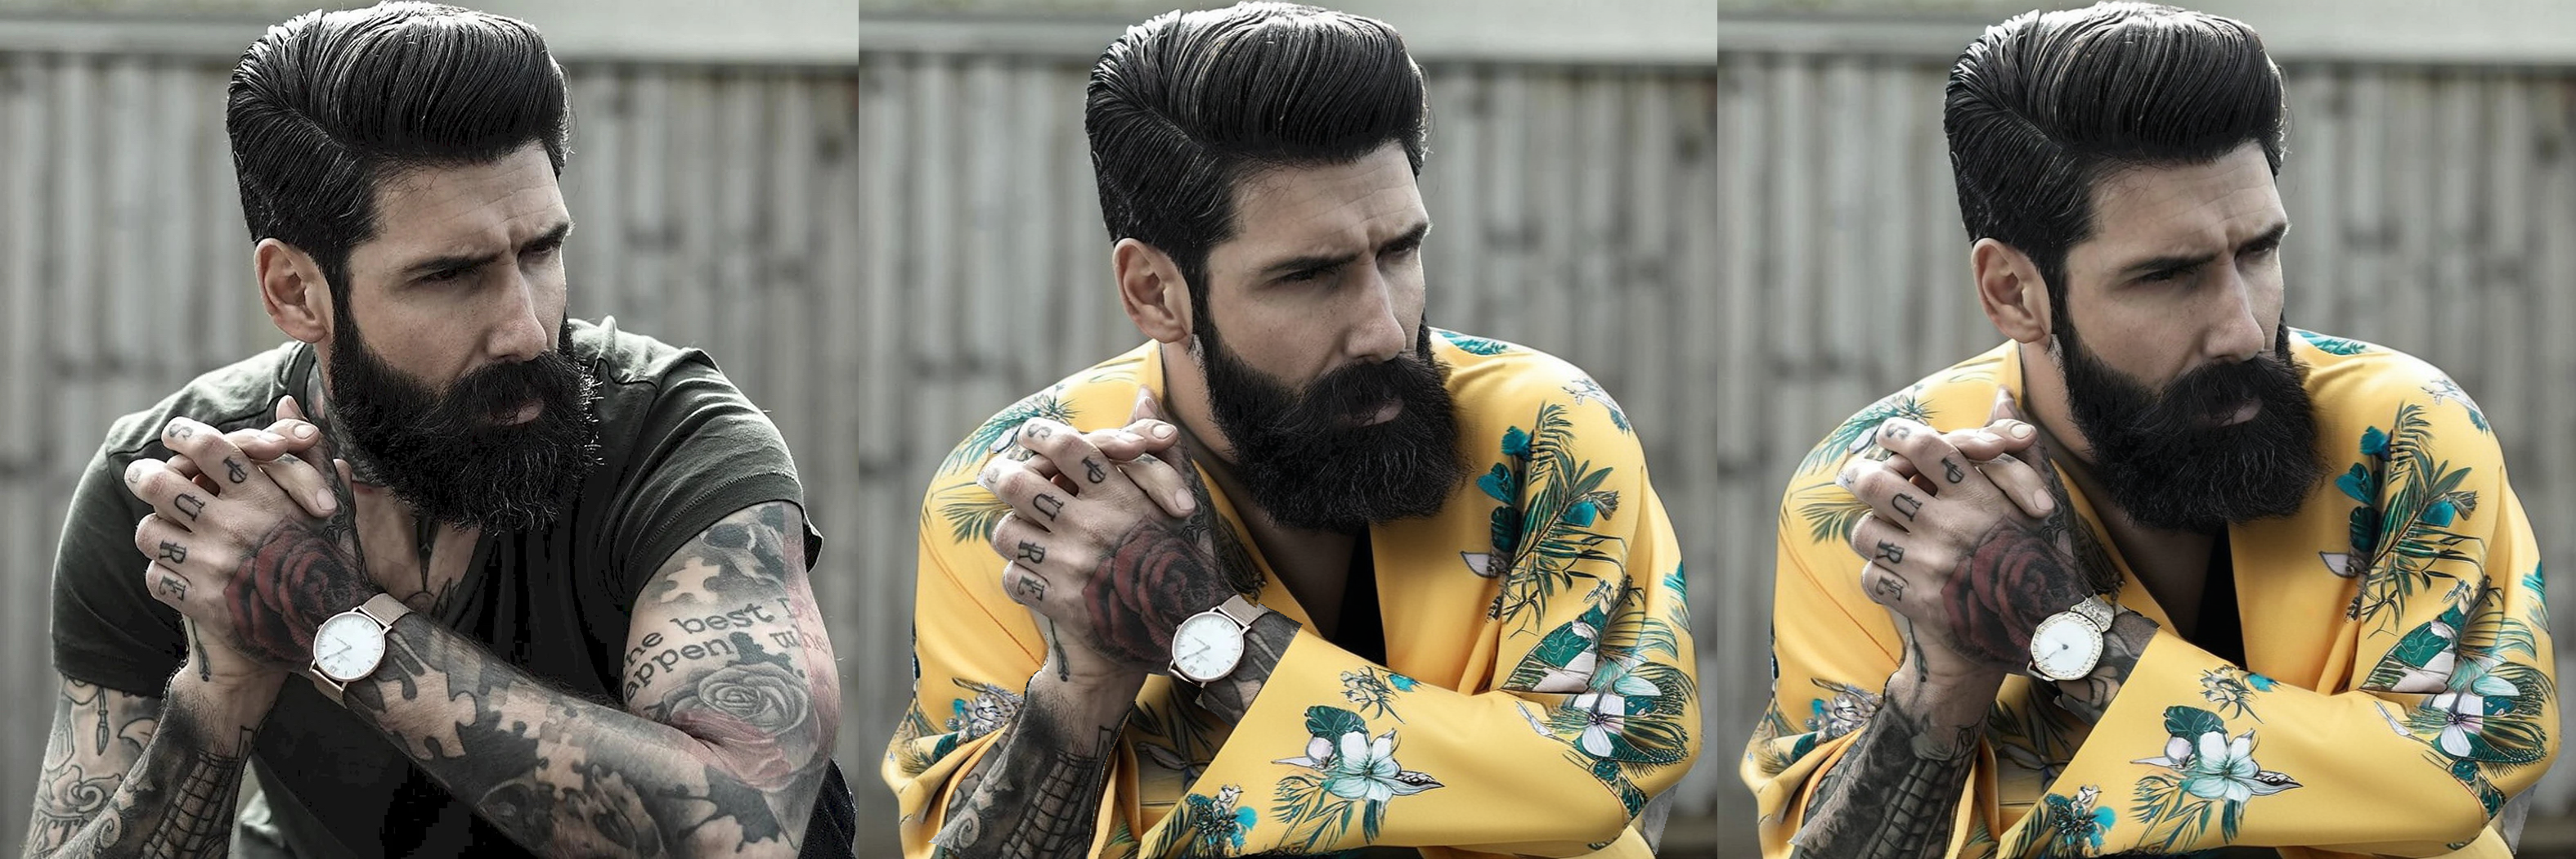

In [78]:
inpaint_pipe.scheduler.config.num_train_timesteps = 200

neg = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), text, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, (blurry:2.0), blur, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, fused fingers, too many fingers"

pose_img, _ = dw_pose(human_img_orig)
pose_img_res = pose_img.resize(more_compose_result.size)
# union_mask_pil = Im(union_mask).convert('L')

arms_class_names = self.segmentaion_config['soft_preservation_classes']

hands_cls = set(['Left_Hand', 'Right_Hand'])
arms_wo_hands_cls = set(arms_class_names) - hands_cls
arms_wo_hands_init_submask = extract_submask(
    segmentation_map=init_segmentation_map,
    submask_classes=arms_wo_hands_cls,
    classes_mapping=init_classes_mapping
)

hands_init_submask = extract_submask(
    segmentation_map=init_segmentation_map,
    submask_classes=hands_cls,
    classes_mapping=init_classes_mapping
)

arms_result_submask = extract_submask(
    segmentation_map=result_segmentation_map,
    submask_classes=arms_class_names,
    classes_mapping=result_classes_mapping,
)

union_mask = np.logical_or(arms_init_submask, arms_result_submask)
union_mask = np.logical_and(union_mask, np.logical_not(hands_init_submask))
union_mask = cv2.dilate(
    union_mask.astype(np.uint8), 
    kernel=np.ones((3, 3), np.uint8),
    iterations=1
) 
union_mask = union_mask > 0

union_mask_pil = Image.fromarray(union_mask).convert('L')
union_mask_pil = union_mask_pil.filter(ImageFilter.GaussianBlur(5))

res = inpaint_pipe(
    prompt=pos_prompt,
    image=more_compose_result,
    mask_image=union_mask_pil,
    strength=0.9,
    num_inference_steps=50,
    guidance_scale=6.0,
    control_image=pose_img_res,
    controlnet_conditioning_scale=0.7,
).images[0]
create_sbs_view(human_img_orig, more_compose_result,res)

In [13]:
for img_name in os.listdir(img_folder):
    img_path = os.path.join(img_folder, img_name)
    
    # Check if the file is an image
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Open the human image
        human_canva = {'background': Image.open(img_path)}
        
        # Process the image using the tryon method
        try:
            result_image = tryon.process_tryon(
                human_canva,
                garm_img,
                garment_des,
                denoise_steps,
                seed,
            )
            
            # Save the result image
            output_path = os.path.join(output_folder, f'result_{img_name}')
            result_image.save(output_path)
            print(f'Saved: {output_path}')
        
        except Exception as e:
            print(f'Error processing {img_name}: {e}')

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


  0%|          | 0/49 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Saved: /workspace/VTO_demo/example/output/result_carlos-costa-beard-1.jpg
Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an ac

Error processing Screenshot 2024-09-21 at 10.11.45.png: tuple index out of range
Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an ac

Error processing Screenshot 2024-09-20 at 20.53.31.png: tuple index out of range
Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


  0%|          | 0/49 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Saved: /workspace/VTO_demo/example/output/result_Screenshot 2024-09-20 at 20.52.59.png
Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an ac

Error processing Screenshot 2024-09-20 at 20.52.43.png: tuple index out of range
Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


  0%|          | 0/49 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Saved: /workspace/VTO_demo/example/output/result_Screenshot 2024-09-20 at 20.52.26.png
Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


  0%|          | 0/49 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Saved: /workspace/VTO_demo/example/output/result_Screenshot 2024-09-20 at 20.50.13.png
Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


  0%|          | 0/49 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Saved: /workspace/VTO_demo/example/output/result_Screenshot 2024-09-20 at 20.49.55.png
Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an ac

Error processing Screenshot 2024-09-20 at 20.49.34.png: tuple index out of range
Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


  0%|          | 0/30 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Loaded as API: http://127.0.0.1:7860/ ✔


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


  0%|          | 0/49 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

Saved: /workspace/VTO_demo/example/output/result_Screenshot 2024-09-20 at 20.21.32.png


In [ ]:
# lost_hairs_mask = (init_submasks['Hair'].astype(int) - result_submasks['Hair']) > 0

# Image.composite(human_img_orig, inpaint_missmatched_result, Im(lost_hairs_mask).resize(org_size))

# create_sbs_view(human_img, inpaint_missmatched_result)